In [77]:
%run ../preprocessing/Artifact_Removal/preprocecssing_helpers.ipynb
%run ../preprocessing/StimCodes.ipynb
%run ../preprocessing/Artifact_Removal/Batch_ArtifactFilter_Epoch.ipynb
%run ../Classification/ConcatEpochTrails.ipynb
%run ../preprocessing/Artifact_Removal/Extract_Describer_Events.ipynb
import os

import mne
from mne.baseline import rescale
from mne.stats import _bootstrap_ci

from sklearn import preprocessing
from mne.decoding import Vectorizer
from sklearn.pipeline import make_pipeline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'preprocecssing_helpers.ipynb.py'` not found.
ERROR:root:File `'Batch_ArtifactFilter_Epoch.ipynb.py'` not found.
ERROR:tornado.application:Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x000001F60094AEA0>)
Traceback (most recent call last):
  File "C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\ipykernel\kernelbase.py", line 306, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable


In [2]:
path = 'D:\stim_code_epochs'
epoch_files = os.listdir(path)

In [3]:
np.random.seed(42)
n = np.random.randint(0,len(epoch_files))
print(n)

102


In [56]:
epoch = mne.read_epochs(os.path.join(path, epoch_files[6]), preload = True)

Reading D:\stim_code_epochs\20140207_1219_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    1949.22 ms
        0 CTF compensation matrices available
940 matching events found
Applying baseline correction (mode: mean)
940 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [32]:
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [57]:
# reduce dimensions of n_times to a point for each band.
montage = mne.channels.read_montage(kind = 'ANT_DukeWaveGuard_128_electrode_montages_updated_V4')
epoch.set_montage(montage);
if 'Nasium' in epoch.ch_names:
    epoch.drop_channels(ch_names=['Nasium', 'LL4', 'L12', 'VEOG']);

The following EEG sensors did not have a position specified in the selected montage: ['Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.


<ipython-input-57-20254dd9ff05>:3: RuntimeWarning: The following EEG sensors did not have a position specified in the selected montage: ['Nasium', 'LL4', 'L12', 'VEOG']. Their position has been left untouched.
  epoch.set_montage(montage);


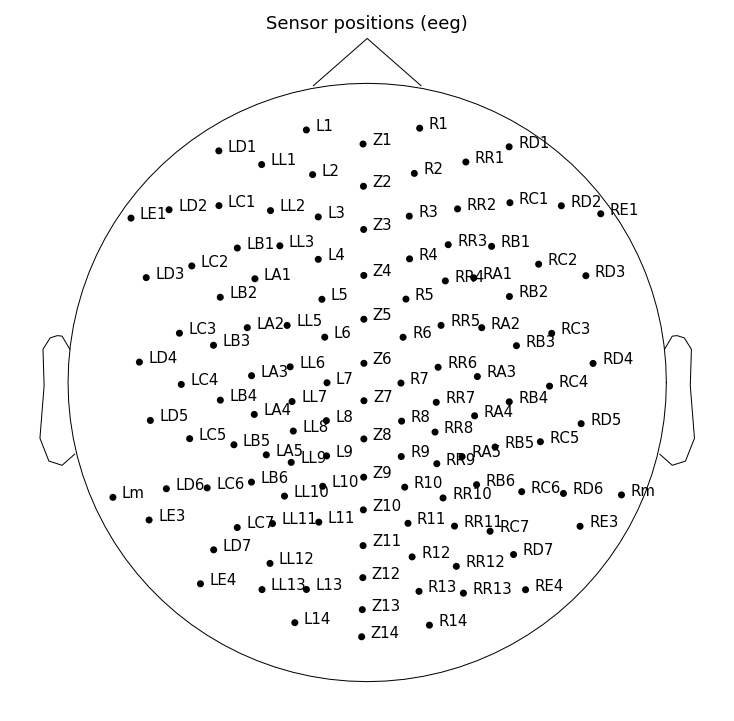

In [58]:
epoch.plot_sensors(show_names=True);

In [ ]:

frequency_map = list()
frequency_data = list()
for band, fmin, fmax in iter_freqs:
    epoch = mne.read_epochs(os.path.join(path, epoch_files[n]), preload = True)
    epoch.drop_channels(['Nasium','Lm','Rm','VEOG'])
    filtered_epoch = epoch.filter(fmin, fmax, n_jobs=1,
                                    l_trans_bandwidth = 1,
                                    h_trans_bandwidth = 1,
                                    fir_design = 'firwin')
    filtered_epoch.subtract_evoked()
    filtered_epoch = mne.EpochsArray(filtered_epoch.get_data(), info = filtered_epoch.info,
                                      tmin = filtered_epoch.tmin, events = filtered_epoch.events)
    frequency_map.append(((band,fmin,fmax), filtered_epoch.average()))
    frequency_data.append(((band,fmin,fmax), filtered_epoch))
    

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = _bootstrap_ci(average.data, random_state=0,
                                  stat_fun=lambda x: np.sum(x ** 2, axis=0))
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel('Time [ms]')

In [ ]:
gamma_epoch = frequency_data[- 1][-1]

In [ ]:
# classify using gamma data and theta data because it has the most spikes
epoch_trials = get_epoch_trials(gamma_epoch)
# convert_event_ids_to_stim_combinations(gamma_epoch,trial_index_list, stim_combinations)
np.array(epoch_trials[0])[:,-1]

In [ ]:
new_events = convert_epoch_events_to_stim_combinations(epoch_object = gamma_epoch)
# new_events[:100]

In [ ]:
trial = np.array(epoch_trials[0])
trial[:,-1] = 1
trial

In [12]:
data = epoch.get_data()

In [17]:
for channel in data:
    print(channel.shape)

(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)
(125, 500)

In [59]:
new_events = convert_epoch_events_to_stim_combinations(epoch)

In [60]:
epoch.events = new_events

In [66]:
# create arrays based on audio and visual
audio_epochs = []
visual_epochs = []

for i in range(len(epoch)): 
    print(i)
    if epoch[i].events[:,-1][0] <700:
        print("audio")
        audio_epochs.append(sample)
    else:
        print("visual")
        visual_epochs.append(sample)

0
visual
1
visual
2
visual
3
visual
4
visual
5
visual
6
visual
7
visual
8
visual
9
visual
10
visual
11
visual
12
visual
13
visual
14
visual
15
visual
16
visual
17
visual
18
visual
19
visual
20
visual
21
visual
22
visual
23
visual
24
visual
25
visual
26
visual
27
visual
28
visual
29
visual
30
visual
31
visual
32
visual
33
visual
34
visual
35
visual
36
visual
37
visual
38
visual
39
visual
40
visual
41
visual
42
visual
43
visual
44
visual
45
visual
46
visual
47
visual
48
visual
49
visual
50
visual
51
visual
52
visual
53
visual
54
visual
55
visual
56
visual
57
visual
58
visual
59
visual
60
visual
61
visual
62
visual
63
visual
64
visual
65
visual
66
visual
67
visual
68
visual
69
visual
70
visual
71
visual
72
visual
73
visual
74
visual
75
visual
76
visual
77
visual
78
visual
79
visual
80
visual
81
visual
82
visual
83
visual
84
visual
85
visual
86
visual
87
visual
88
visual
89
visual
90
visual
91
visual
92
visual
93
visual
94
visual
95
visual
96
visual
97
visual
98
visual
99
visual
100
visual

audio
823
audio
824
audio
825
audio
826
audio
827
audio
828
audio
829
audio
830
audio
831
audio
832
audio
833
audio
834
audio
835
audio
836
audio
837
audio
838
audio
839
audio
840
audio
841
audio
842
audio
843
audio
844
audio
845
audio
846
audio
847
audio
848
audio
849
audio
850
audio
851
audio
852
audio
853
audio
854
audio
855
audio
856
audio
857
audio
858
audio
859
audio
860
audio
861
audio
862
audio
863
audio
864
audio
865
audio
866
audio
867
audio
868
audio
869
audio
870
audio
871
audio
872
audio
873
audio
874
audio
875
audio
876
audio
877
audio
878
audio
879
audio
880
audio
881
audio
882
audio
883
audio
884
audio
885
visual
886
visual
887
visual
888
visual
889
visual
890
visual
891
visual
892
visual
893
visual
894
visual
895
visual
896
visual
897
visual
898
visual
899
visual
900
visual
901
visual
902
visual
903
visual
904
visual
905
visual
906
visual
907
visual
908
visual
909
visual
910
visual
911
visual
912
visual
913
visual
914
visual
915
visual
916
visual
917
visual
918
visual


In [88]:
pipeline = make_pipeline(Vectorizer(), StandardScaler())
scaled_audio_data = pipeline.fit_transform(audio_epochs)
scaled_visual_data = pipeline.fit_transform(visual_epochs)

In [90]:
vectorizer = make_pipeline(Vectorizer())
vectorized_audio_data = vectorizer.fit_transform(audio_epochs)
vectorized_visual_data = vectorizer.fit_transform(visual_epochs)


In [91]:
scaled_audio_data = preprocessing.scale(vectorized_audio_data)
scaled_visual_data = preprocessing.scale(vectorized_visual_data)

C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\preprocessing\data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\Emmanuil\Anaconda3\envs\mne\lib\site-packages\sklearn\preprocessing\data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [92]:
audio_variance = []
for data in scaled_visual_data:
#     print(data)
    audio_variance.append(np.var(data))
visual_variance = []
for data in scaled_visual_data:
    visual_variance.append(np.var(data))

In [93]:
audio_variance

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0